[Datitos: Aprendizaje profundo](https://datitos.github.io/curso-aprendizaje-profundo/)

[T.P. N°2 - Aprendizaje Profundo 2021 by Datitos](https://www.kaggle.com/c/tp-n2-aprendizaje-profundo-2021-by-datitos-v2)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

In [3]:
import numpy as np
import pandas as pd

import torch
from torch.nn import Sequential, Linear, ReLU, Dropout, Softmax, MSELoss
from torch.optim import Adam

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from callbacks import PlotLosses, Logger, ReduceLROnPlateau, TrainValLossComputer
from model import Model
from utils import try_gpu
from callbacks import CallbackSet

In [4]:
train_set = pd.read_csv('./dataset/fifa2021_training.csv')

In [5]:
# ProfileReport(train_set, title="Exploratory Analisys", explorative=True)to_file("report.html")

In [6]:
SKILL_FEATURES = [
    'BallControl', 'Dribbling', 'Marking', 'SlideTackle', 'StandTackle', 'Aggression',
    'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing', 'ShortPass',
    'LongPass', 'Acceleration', 'Stamina', 'Strength', 'Balance', 'SprintSpeed',
    'Agility', 'Jumping', 'Heading', 'ShotPower', 'Finishing', 'LongShots',
    'Curve', 'FKAcc', 'Penalties', 'Volleys', 'GKDiving', 'GKHandling',
    'GKKicking', 'GKReflexes'
]
TARGET = 'Position'

In [7]:
def preprocess(df): return df[SKILL_FEATURES], pd.get_dummies(df[[TARGET]], dummy_na=True)

In [8]:
X, y = preprocess(train_set)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11136, 32), (11136, 5), (2785, 32), (2785, 5))

In [26]:
class MyModel(Model):
    def __init__(self, X_train, y_train, n_hidden=100, lr=0.001, dropout=0.1):
        model = Sequential(
            Linear(X_train.shape[1], n_hidden), 
            ReLU(),
            Dropout(dropout),
            Linear(n_hidden, y_train.shape[1]), 
            ReLU(),
            Dropout(dropout),
            Softmax(dim=1)
        ).to(device=try_gpu())

        super().__init__(model, MSELoss(), Adam(model.parameters(), lr=lr))

In [27]:
model = MyModel(X_train, y_train).info()

Model:
 Sequential(
  (0): Linear(in_features=32, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=5, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Softmax(dim=1)
)
Params:
 [('0.weight', torch.Size([100, 32])), ('0.bias', torch.Size([100])), ('3.weight', torch.Size([5, 100])), ('3.bias', torch.Size([5]))]


### Train

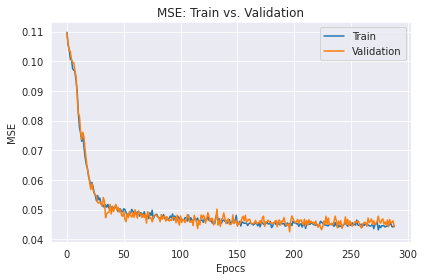

{'epoch': 300, 'lr': 1.0000000000000002e-06, 'train_loss': 0.04361988976597786, 'val_loss': 0.04472053050994873}


In [28]:
model.fit(
    train_set    = (X_train, y_train), 
    val_set      = (X_val, y_val),
    batch_size   = 2000,
    epochs       = 300,
    callback_set = CallbackSet([
        TrainValLossComputer(),
        PlotLosses(warmup_count=10),
        Logger(metrics=['epoch', 'train_loss', 'val_loss', 'lr']),
        ReduceLROnPlateau(patience=40)
    ])
)

### Predict

In [29]:
first_example_feat   = X_val.iloc[1:2, :]
first_example_target = y_val.iloc[1:2, :]

In [30]:
model.predict(first_example_feat)

array([[0.01220337, 0.01220337, 0.01220337, 0.95118654, 0.01220337]],
      dtype=float32)

In [31]:
first_example_target

,Position_DEF,Position_FWD,Position_GK,Position_MID,Position_nan
3058,0,0,0,1,0
